In [1]:
import os
import random

import numpy as np
from numpy import random
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from ultralytics import YOLO # yolov8

from torchinfo import summary

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define model and check

In [20]:
models = YOLO('model/yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:04<00:00, 11.2MB/s]


In [ ]:
summary(
    model = models,
    input_size = (1, 3, 384, 640),
    # input_data = None,
    batch_dim =  None,
    cache_forward_pass = None,
    col_names =  None,
    col_width = 25,
    depth = 3,
    device = 0,
    dtypes = None,
    mode = None,
    row_settings = None,
    verbose= 1,
)

Layer (type:depth-idx)                                  Param #
YOLO                                                    --
├─DetectionModel: 1-1                                   --
│    └─Sequential: 2-1                                  --
│    │    └─Conv: 3-1                                   (2,320)
│    │    └─Conv: 3-2                                   (115,520)
│    │    └─C2f: 3-3                                    (436,800)
│    │    └─Conv: 3-4                                   (461,440)
│    │    └─C2f: 3-5                                    (3,281,920)
│    │    └─Conv: 3-6                                   (1,844,480)
│    │    └─C2f: 3-7                                    (13,117,440)
│    │    └─Conv: 3-8                                   (3,687,680)
│    │    └─C2f: 3-9                                    (6,969,600)
│    │    └─SPPF: 3-10                                  (1,025,920)
│    │    └─Upsample: 3-11                              --
│    │    └─Concat: 3-12     

Layer (type:depth-idx)                                  Param #
YOLO                                                    --
├─DetectionModel: 1-1                                   --
│    └─Sequential: 2-1                                  --
│    │    └─Conv: 3-1                                   (2,320)
│    │    └─Conv: 3-2                                   (115,520)
│    │    └─C2f: 3-3                                    (436,800)
│    │    └─Conv: 3-4                                   (461,440)
│    │    └─C2f: 3-5                                    (3,281,920)
│    │    └─Conv: 3-6                                   (1,844,480)
│    │    └─C2f: 3-7                                    (13,117,440)
│    │    └─Conv: 3-8                                   (3,687,680)
│    │    └─C2f: 3-9                                    (6,969,600)
│    │    └─SPPF: 3-10                                  (1,025,920)
│    │    └─Upsample: 3-11                              --
│    │    └─Concat: 3-12     


image 1/1 c:\Users\My computer\Downloads\School\Personal Education\Github\Artificial-Intelligent-Skills\8. Deep Learning\Computer Vision\Mini Project\Multiple Object Tracking In Real-Time\person.jpg: 384x640 2 persons, 2 cups, 1 bowl, 1 chair, 1 couch, 1 potted plant, 1 dining table, 1 vase, 215.3ms
Speed: 6.1ms preprocess, 215.3ms inference, 356.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to test\attempt


Class: cup
Class: cup
Class: dining table
Class: bowl
Class: person
Class: vase
Class: person
Class: couch
Class: chair
Class: potted plant


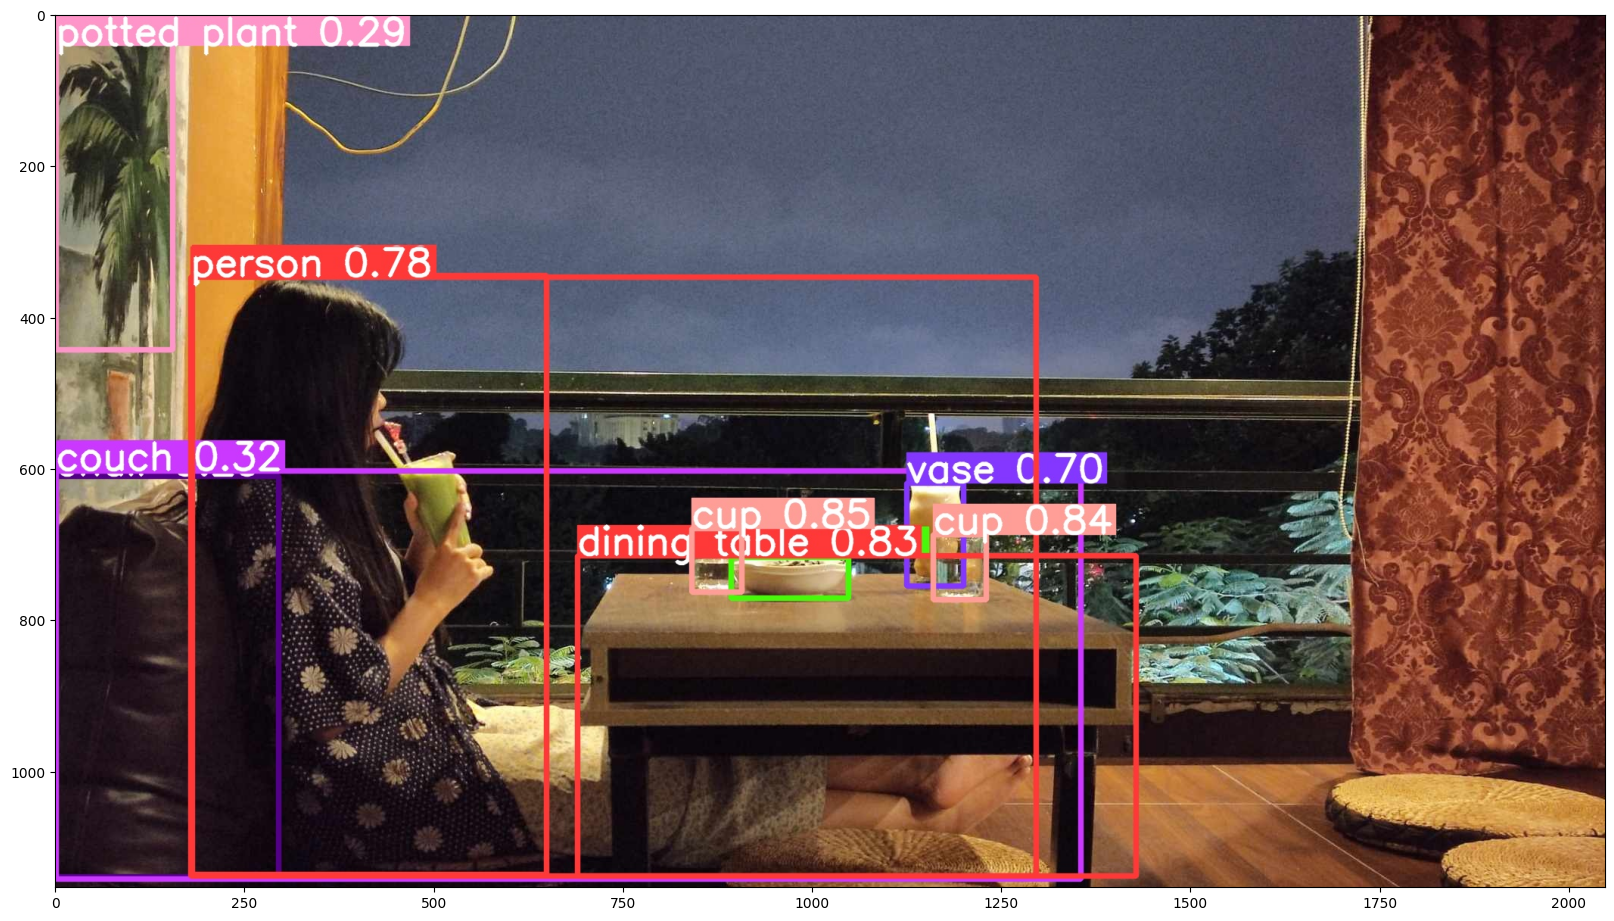

In [5]:
results = models.predict(source=r'/path/to/image', project='test', name='attempt', save_conf=True, save=True)

class_names = models.names

for result in results:
    boxes = result.boxes  
    probs = result.probs  
    cls = boxes.cls.tolist() 
    xyxy = boxes.xyxy 
    xywh = boxes.xywh 
    conf = boxes.conf 
    for class_index in cls:
        class_name = class_names[int(class_index)]
        print("Class:", class_name)
        
plt.figure(figsize=(20,20))
plt.imshow(Image.open(r"/path/to/image"))
plt.show()

# DeepSort

In [4]:
from deep_sort.utils.parser import get_config
from deep_sort.deep_sort import DeepSort
from collections import deque

In [5]:
data_deque = {}
deep_sort = None
object_counter = {}
object_counter1 = {}
line = None

In [6]:
def line_def(line, vid_path):
    """
    Create a line that equal to video width
    :param line: line position
    :param vid_path: video path
    :return: line
    """
    cap = cv2.VideoCapture(vid_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    line = [(0, 500), (width, 500)]
    return line

In [7]:
def init_tracker():
    global deep_sort
    cfg_deep = get_config()
    cfg_deep.merge_from_file("deep_sort/configs/deep_sort.yaml")

    deep_sort= DeepSort(cfg_deep.DEEPSORT.REID_CKPT,
                            max_dist=cfg_deep.DEEPSORT.MAX_DIST, min_confidence=cfg_deep.DEEPSORT.MIN_CONFIDENCE,
                            nms_max_overlap=cfg_deep.DEEPSORT.NMS_MAX_OVERLAP, max_iou_distance=cfg_deep.DEEPSORT.MAX_IOU_DISTANCE,
                            max_age=cfg_deep.DEEPSORT.MAX_AGE, n_init=cfg_deep.DEEPSORT.N_INIT, nn_budget=cfg_deep.DEEPSORT.NN_BUDGET,
                            use_cuda=True)

In [8]:
def compute_color_for_labels(label):
    """
    Compute a color for a given label.
    :param label: The label for which to compute the color.
    :return: The computed color as a tuple of RGB values.
    """
    color = label % 16_777_216  # Limit the label to the range of 0 to 16,777,215
    r = (color // 65536) % 256
    g = (color // 256) % 256
    b = color % 256
    return r, g, b

In [9]:
def draw_border(img, pt1, pt2, color, thickness, r, d):
    '''
    Draw a fancy border around the given image
    :param img: The image to draw the border on.
    :param pt1: Top left point.
    :param pt2: Bottom right point.
    :param color: Color of the border.
    :param thickness: Thickness of the border.
    :param r: Border radius.
    :param d: Border line length.
    :return: The image with the drawn border.
    '''
    
    x1,y1 = pt1
    x2,y2 = pt2
    # Top left
    cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
    # Top right
    cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
    # Bottom left
    cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
    # Bottom right
    cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)

    cv2.rectangle(img, (x1 + r, y1), (x2 - r, y2), color, -1, cv2.LINE_AA)
    cv2.rectangle(img, (x1, y1 + r), (x2, y2 - r - d), color, -1, cv2.LINE_AA)
    
    cv2.circle(img, (x1 +r, y1+r), 2, color, 12)
    cv2.circle(img, (x2 -r, y1+r), 2, color, 12)
    cv2.circle(img, (x1 +r, y2-r), 2, color, 12)
    cv2.circle(img, (x2 -r, y2-r), 2, color, 12)
    
    return img

In [10]:
def UI_box(x, img, color=None, label=None, line_thickness=None):
    """
    Draws a UI box on the image
    :param x: The coordinates of the box.
    :param img: The image to draw the box on.
    :param color: The color of the box.
    :param label: The label of the box.
    :param line_thickness: The thickness of the box.
    :return: The image with the drawn box.
    """
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]

        img = draw_border(img, (c1[0], c1[1] - t_size[1] -3), (c1[0] + t_size[0], c1[1]+3), color, 1, 8, 2)

        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

In [11]:
def create_new_task_folder(base_path, video_name):
    """
    Create a new task folder with the name of the video under the 'runs' directory.
    :param base_path: The base directory for the 'runs' folder.
    :param video_name: The name of the video file.
    :return: The path to the newly created task folder.
    """
    task_folder = os.path.join(base_path, video_name)
    os.makedirs(task_folder, exist_ok=True)
    return task_folder

In [12]:
def ccw(A,B,C):
    """
    Check if three points are listed in a counterclockwise order
    :param A: First point
    :param B: Second point
    :param C: Third point
    :return: True if listed counterclockwise, False otherwise
    """
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

In [13]:
def intersect(A,B,C,D):
    """
    Check if two lines intersect
    :param A: First point of first line
    :param B: Second point of first line
    :param C: First point of second line
    :param D: Second point of second line
    :return: True if the lines intersect, False otherwise
    """
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [14]:
def get_direction(point1, point2):
    """
    Get the direction of the object movement
    :param point1: The first point of the object.
    :param point2: The second point of the object.
    :return: The direction of the object movement.
    """
    direction_str = ""

    # calculate y axis direction
    if point1[1] > point2[1]:
        direction_str += "South"
    elif point1[1] < point2[1]:
        direction_str += "North"
    else:
        direction_str += ""

    # calculate x axis direction
    if point1[0] > point2[0]:
        direction_str += "East"
    elif point1[0] < point2[0]:
        direction_str += "West"
    else:
        direction_str += ""

    return direction_str

In [15]:
def draw_boxes(img, bbox, names, object_id, identities=None, offset=(0, 0)):
    """
    Draws the bounding boxes on the image.
    :param img: The image to draw the bounding boxes on.
    :param bbox: The bounding boxes.
    :param names: The names of the objects.
    :param identities: The identities of the objects.
    :param offset: The offset of the bounding boxes.
    :return: The image with the drawn bounding boxes.
    """
    
    cv2.line(img, line[0], line[1], (46,162,112), 3)

    height, width, _ = img.shape
    # remove tracked point from buffer if object is lost
    for key in list(data_deque):
      if key not in identities:
        data_deque.pop(key)

    for i, box in enumerate(bbox):
        x1, y1, x2, y2 = [int(i) for i in box]
        x1 += offset[0]
        x2 += offset[0]
        y1 += offset[1]
        y2 += offset[1]

        # code to find center of bottom edge
        center = (int((x2+x1)/ 2), int((y2+y2)/2))

        # get ID of object
        id = int(identities[i]) if identities is not None else 0

        # create new buffer for new object
        if id not in data_deque:  
          data_deque[id] = deque(maxlen= 64)
        if i < len(object_id):
            color = compute_color_for_labels(object_id[i])
            obj_name = names[object_id[i]]
            label = '{}{:d}'.format("", id) + ":"+ '%s' % (obj_name)
        else:
            continue

        # add center to buffer
        data_deque[id].appendleft(center)
        if len(data_deque[id]) >= 2:
          direction = get_direction(data_deque[id][0], data_deque[id][1])
          if intersect(data_deque[id][0], data_deque[id][1], line[0], line[1]):
              cv2.line(img, line[0], line[1], (255, 255, 255), 3)
              if "South" in direction:
                if obj_name not in object_counter:
                    object_counter[obj_name] = 1
                else:
                    object_counter[obj_name] += 1
              if "North" in direction:
                if obj_name not in object_counter1:
                    object_counter1[obj_name] = 1
                else:
                    object_counter1[obj_name] += 1

        UI_box(box, img, label=label, color=color, line_thickness=2)
        # draw trail
        for i in range(1, len(data_deque[id])):
            # check if on buffer value is none
            if data_deque[id][i - 1] is None or data_deque[id][i] is None:
                continue
            # generate dynamic thickness of trails
            thickness = int(np.sqrt(64 / float(i + i)) * 1.5)
            # draw trails
            cv2.line(img, data_deque[id][i - 1], data_deque[id][i], color, thickness)
    
    #4. Display Count in top right corner
        for idx, (key, value) in enumerate(object_counter1.items()):
            cnt_str = str(key) + ":" + str(value)
            cv2.line(img, (width - 500,25), (width,25), [85,45,255], 40)
            cv2.putText(img, f'Number of Object Entering', (width - 500, 35), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_AA)
            cv2.line(img, (width - 150, 65 + (idx*40)), (width, 65 + (idx*40)), [85, 45, 255], 30)
            cv2.putText(img, cnt_str, (width - 150, 75 + (idx*40)), 0, 1, [255, 255, 255], thickness = 2, lineType = cv2.LINE_AA)

        for idx, (key, value) in enumerate(object_counter.items()):
            cnt_str1 = str(key) + ":" +str(value)
            cv2.line(img, (20,25), (500,25), [85,45,255], 40)
            cv2.putText(img, f'Numbers of Object Leaving', (11, 35), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_AA)    
            cv2.line(img, (20,65+ (idx*40)), (127,65+ (idx*40)), [85,45,255], 30)
            cv2.putText(img, cnt_str1, (11, 75+ (idx*40)), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_AA)
    
    return img

In [16]:
def frames_to_video(input_path, output_path, fps = 30.0):
    """
    Convert a folder of images to a video.
    :param input_path: The path to the folder of images.
    :param output_path: The path to the output video.
    :param fps: The FPS of the output video.
    :return: None
    """
    # Get the list of folders in the input directory
    folders = [f for f in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, f))]

    # Process each folder separately
    for folder in folders:
        folder_path = os.path.join(input_path, folder)
        image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
        print(f"Image files in {folder_path}: {image_files}")  # Debugging print statement

        if not image_files:
            print(f"No .jpg files found in {folder_path}")
            continue

        frame = cv2.imread(os.path.join(folder_path, image_files[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(os.path.join(output_path, f"{folder}.mp4"), cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

        for image_file in image_files:
            video.write(cv2.imread(os.path.join(folder_path, image_file)))

        cv2.destroyAllWindows()
        video.release()

# Training Part

In [17]:
models.train(
    data = r'/path/to/data.yaml',
    epochs = 100,
    batch_size = 16,
    imgsz = 640,
    device = 0,
)

# https://docs.ultralytics.com/modes/train/#arguments

New https://pypi.org/project/ultralytics/8.0.205 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.199  Python-3.11.6 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=model/yolov8x.pt, data=coco8.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, aug

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0, 16, 17, 20, 25, 58])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018724F18BD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047

# Testing / Predict

In [18]:
def predict(video_path, base_path = os.getcwd()):
    # Get the video name
    video_name = os.path.basename(video_path).split('.')[0]

    # Create a new task folder
    task_folder = create_new_task_folder(base_path, video_name)
    print(f"New task folder: {task_folder}")

    # Initialize the video capture object
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video stream or file")
        return
                
    # Initialize the deep sort tracker
    init_tracker()

    # Get the video frame width and height
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create a video writer object to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(os.path.join(task_folder, f"{video_name}.mp4"), fourcc, 30, (width, height))

    # Read until video is completed
    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret:
            # Perform inference
            results = models.track(frame, conf=0.4)
            class_names = models.names

            for result in results:
                boxes = result.boxes  # Boxes object for bbox outputs
                cls = boxes.cls.tolist()  # Convert tensor to list
                xyxy = boxes.xyxy
                conf = boxes.conf
                xywh = boxes.xywh  # box with xywh format, (N, 4)

            conf = conf.detach().cpu().numpy()
            xyxy = xyxy.detach().cpu().numpy()
            bboxes_xywh = xywh
            bboxes_xywh = xywh.cpu().numpy()
            bboxes_xywh = np.array(bboxes_xywh, dtype=float)
                
            # Perform tracking
            outputs = deep_sort.update(bbox_xywh= bboxes_xywh, confidences=conf, ori_img=frame)

            # Draw boxes for visualization
            if len(outputs) > 0:
                bbox_xyxy = outputs[:, :4]
                identities = outputs[:, -1]
                frame = draw_boxes(frame, bbox_xyxy, class_names, cls, identities)

            # Save the output frame
            out.write(frame)
        else:
            break

    # Release the video capture and writer objects
    cap.release()
    out.release()
    print("Prediction completed.")

In [69]:
%%time
if __name__ == '__main__':
    # Creating a function to detect and tracking multiple object
    # frame_to_video(input_path = /path/to/image/folder, output_path = /path/to/video/folder, fps = 30.0)
    vid_path = r"/path/to/video"
    line = line_def(line, vid_path)
    predict(vid_path)

New task folder: c:\Users\My computer\Downloads\School\Personal Education\Github\Artificial-Intelligent-Skills\8. Deep Learning\Computer Vision\Mini Project\Multiple Object Tracking In Real-Time\Highway (Long)



0: 384x640 6 cars, 47.2ms
Speed: 2.0ms preprocess, 47.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 44.5ms
Speed: 1.0ms preprocess, 44.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 41.8ms
Speed: 1.0ms preprocess, 41.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 39.2ms
Speed: 2.0ms preprocess, 39.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 40.1ms
Speed: 1.0ms preprocess, 40.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 39.4ms
Speed: 1.0ms preprocess, 39.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

Prediction completed.
CPU times: total: 4min 7s
Wall time: 7min 52s
